In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!cp -v "/content/gdrive/MyDrive/AVSpeech-Dataset/Sample_1100.zip" './Sample_1100.zip' 
!unzip -o './Sample_1100.zip' 
!rm './Sample_1100.zip' 

In [ ]:
import os 
import shutil 
import glob
import cv2
os.mkdir("/content/trainData")
for i in range(0,15000):
  x = 0
  if i == 1:
    continue
  for d in glob.glob(f"/content/Sample_1100/frames/{i}/*"):
    im = cv2.imread(d)
    im = cv2.resize(im,(224,224))
    cv2.imwrite(f"/content/trainData/{i}_{x}.png", im)
    x += 1

In [ ]:
os.mkdir("/content/testData")
for d in glob.glob(f"/content/Sample_1100/frames/1/*"):
  im = cv2.imread(d)
  im = cv2.resize(im,(224,224))
  cv2.imwrite(f"/content/testData/{i}_{x}.png", im)
  x += 1

In [ ]:
os.mkdir("/content/train/")

In [ ]:
pip install torchfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=738acc5046697140d529cfcdbb63b9855482c69b3729689f84e356eab0e26a63
  Stored in directory: /root/.cache/pip/wheels/b9/99/d1/9f3f4411a958a22ccf782e33c7238a07f04a9597f2f3b38792
Successfully built torchfile


In [ ]:
import numpy as np
import cv2
import torch


import torch.nn as nn
import torch.nn.functional as F
import torchfile

from torch.utils.data import Dataset, DataLoader
import os


import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import time

torch.cuda.empty_cache()

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz

--2023-03-03 00:31:18--  http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz [following]
--2023-03-03 00:31:18--  https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541127779 (516M) [application/x-gzip]
Saving to: ‘vgg_face_torch.tar.gz’

vgg_face_torch.tar. 100%[===================>] 516.06M  28.8MB/s    in 20s     

2023-03-03 00:31:38 (25.8 MB/s) - ‘vgg_face_torch.tar.gz’ saved [541127779/541127779]



In [ ]:
!tar -xzf  "/content/vgg_face_torch.tar.gz"

In [ ]:
#VGG-16 Face Encoder Class

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchfile



class VGG_16(nn.Module):
    """
    Main Class
    """

    def __init__(self):
        """
        Constructor
        """
        super().__init__()
        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2622)

    def load_weights(self, path="/content/vgg_face_torch/VGG_FACE.t7"):

        """ Function to load luatorch pretrained
        Args:
            path: path for the luatorch pretrained
        """
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                else:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x):
        """ Pytorch forward
        Args:
            x: input image (224x224)
        Returns: class logits
        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        #return self.fc7(x) #new added
        #return F.relu(self.fc7(x))

        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)

        x = F.normalize(x, p=2, dim=1)
        return x

        #return self.fc8(x) 


    def forward_two(self, x):
        """ Pytorch forward
        Args:
            x: input image (224x224)
        Returns: class logits
        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)
        return self.fc8(x)

In [ ]:
encoder = VGG_16().cuda()
encoder.load_weights()
encoder.eval()

VGG_16(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_3): 

In [ ]:
class FrontFacingNeutralDataset(Dataset):

  def __init__(self, dataPath, img_list, transform=None):
        super(FrontFacingNeutralDataset, self).__init__()

        """
        if os.path.isdir(dataPath):
          print("train Dataset Already Downloaded!")
        else:
          print("train DATASET NOT PRESENT!")
        """
       

       
        self.transform = transform
        self.textures,self.encodings,self.length = self.loadToMem(dataPath, img_list)
        
        

    
    

  def loadToMem(self, dataPath, img_list): 

        print("begin loading samples to memory")
        ttextures = []
        eencodings = []
        llength = 0
            
        for imgPath in img_list:
              filePath = os.path.join(dataPath, imgPath)
              opencv_img = cv2.imread(filePath)
              opencv_img = cv2.resize(opencv_img, (224, 224))
              if opencv_img is not None:
                  

                  
                  ttextures.append(opencv_img)
                  opencv_img2=opencv_img[:,:,[2,1,0]]

                  x=torch.Tensor(opencv_img2)
                  x = x.permute(2,0,1).view(1, 3, 224, 224).cuda()#.double() #change order of dimensions and add dimension
                  x = (x - 127.5) / 128.0
                                    
                          
                  img_embedding = encoder(x).cpu().detach().numpy()


                  eencodings.append(img_embedding)
           
                  llength += 1

              #if(llength%5000==0): print(llength, " loaded")

              if(llength==990): break

        print("finish loading samples to memory")
        print(llength, " samples loaded!")
        return ttextures, eencodings,llength

  def __len__(self):
        return  self.length

  def __getitem__(self, index):

       #x=torch.Tensor(self.textures[index]).cuda()
        #x = x.permute(2,0,1).view(1, 3, 224, 224)#.double() #change order of dimensions and add dimension

        #.double()
        #x -= torch.Tensor(np.array([129.1863, 104.7624, 93.5940])).view(1, 3, 1, 1).cuda() #standardize
        #texture_4096=self.encoder(x).cpu()

        
        #return self.textures[index], self.landmarks[index], texture_4096
        return self.textures[index], self.encodings[index]
          

In [ ]:
class TestDataset(Dataset):

  def __init__(self, dataPath, transform=None):
        super(TestDataset, self).__init__()

        if os.path.isdir(dataPath):
          print("Test Dataset Already Downloaded!")
        else:
          print("DECODER test DATASET NOT PRESENT!")
       

       
        self.transform = transform
        self.textures,self.encodings,self.length = self.loadToMem(dataPath)
        
        

    
    

  def loadToMem(self, dataPath): 

        print("begin loading training dataset to memory")
        ttextures = []
        eencodings = []
        llength = 0
            
        for imgPath in os.listdir(dataPath):
              filePath = os.path.join(dataPath, imgPath)
              opencv_img = cv2.imread(filePath)
              opencv_img = cv2.resize(opencv_img, (224, 224))

              if opencv_img is not None:

                    
                  ttextures.append(opencv_img)
                  opencv_img2=opencv_img[:,:,[2,1,0]]

                  x=torch.Tensor(opencv_img2)
                  x = x.permute(2,0,1).view(1, 3, 224, 224).cuda()#.double() #change order of dimensions and add dimension
                  x = (x - 127.5) / 128.0
                                    
                          
                  img_embedding = encoder(x).cpu().detach().numpy()


                  eencodings.append(img_embedding)


                  llength += 1

              if(llength%10==0): print(llength, " loaded")

              if(llength==20): break

        print("finish loading TEST dataset to memory")
        return ttextures, eencodings,llength

  def __len__(self):
        return  self.length

  def __getitem__(self, index):

       #x=torch.Tensor(self.textures[index]).cuda()
        #x = x.permute(2,0,1).view(1, 3, 224, 224)#.double() #change order of dimensions and add dimension

        #.double()
        #x -= torch.Tensor(np.array([129.1863, 104.7624, 93.5940])).view(1, 3, 1, 1).cuda() #standardize
        #texture_4096=self.encoder(x).cpu()

        
        #return self.textures[index], self.landmarks[index], texture_4096
        return self.textures[index], self.encodings[index]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchfile
import numpy as np

class Decoder(nn.Module):

    def __init__(self, batchSize):
        super(Decoder, self).__init__()
      

        #Multi-Layer Perceptron Layer
        self.mlp = nn.Sequential(nn.Linear(4096,1000), nn.ReLU(), nn.Linear(1000,50176), nn.ReLU()) #14x14x256
        
        #Texture generator
        self.texture_gen = nn.Sequential(
             #14x14x256
            nn.ConvTranspose2d(256, 128, 6, stride=2,padding=2),
        
            nn.ReLU(),
            
            #28x28x128
            nn.ConvTranspose2d(128, 64, 6, stride=2,padding=2),
           
            nn.ReLU(),

            #56x56x64
            nn.ConvTranspose2d(64, 32, 6, stride=2,padding=2),

            nn.ReLU(),

            #112x112x32
            nn.ConvTranspose2d(32, 32, 6, stride=2,padding=2),
         
            nn.ReLU(),

            #224x224x32
            nn.Conv2d(32,3,1,stride=1),nn.Sigmoid()

            #224x224x3
        )
        self.batch_size=batchSize




    def forward(self, x):
        

        x=self.mlp(x)
   
        x=x.view(self.batch_size,256,14,14)
        texture=self.texture_gen(x)

        return texture


    def forward_test(self, x):
        
  
        x=self.mlp(x)
        #Remember to remove comments and retrun tx
        #TODO::
        #Remember to change it later !!!!!!!!
        x=x.view(20,256,14,14)
        texture=self.texture_gen(x)

        #np_texture = texture.cpu().detach().numpy()

        #tx=np.moveaxis(np_texture[0], 0, -1) *255.0
        #tx=np.rint(tx)
        #tx=tx.astype('uint8')
            

        return  texture



    def test(self,x,encoder):
        x=torch.Tensor(x)
        x = x.permute(2,0,1).view(1, 3, 224, 224)
        x -= torch.Tensor(np.array([129.1863, 104.7624, 93.5940])).view(1, 3, 1, 1) #standardize
        x = x.to(device='cuda')
        x = encoder(x)
        x=self.mlp(x.type(torch.float))
     
        x=x.view(1,256,14,14)
        texture=self.texture_gen(x)

        np_texture = texture.cpu().detach().numpy()

        tx=np.moveaxis(np_texture[0], 0, -1) *255.0
        tx=np.rint(tx)
        tx=tx.astype('uint8')
            


        return  tx

In [ ]:
batchSize= 110
learning_rate=0.0006 #0.00001
dataPath="/content/trainData"
workers=0 #number of dataLoader workers
curr_epoch=1
 
net = Decoder(batchSize)


net.cuda()


optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#checkpoint = torch.load("/content/gdrive/My Drive/*FYP_DATA*/saved_models/spring-facenet-epoch-560.pt")
#net.load_state_dict(checkpoint['net_state_dict'])
#curr_epoch = checkpoint['curr_epoch']

net.eval()

Decoder(
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=50176, bias=True)
    (3): ReLU()
  )
  (texture_gen): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
    (8): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
  )
)

In [ ]:
testSet = TestDataset("/content/testData")
testLoader = DataLoader(testSet, batch_size=20, shuffle=False)

def testset_loss():
  net.eval()
  for i, data in enumerate(testLoader, 0):
    textures, encodings = data
    textures, encodings = textures.cuda(), encodings.cuda()
    encodings=encodings.float()
    encodings = torch.squeeze(encodings,1)
    outputs = net.forward_test(encodings)
    gen_textures = outputs
    gen_textures = (gen_textures*255.0)
    textures = textures.permute(0,3,1,2).type(torch.float)
    loss1 = torch.nn.L1Loss()(gen_textures, textures)
    gen_textures=gen_textures[:,[2,1,0],:,:]
    x=gen_textures
    x = (x - 127.5) / 128.0
    gen_encodings = encoder(x)
    loss2 = (-1) * torch.nn.CosineSimilarity()(gen_encodings, encodings)
    loss2 = loss2.sum()
    final_loss = loss1 + loss2
    t_loss1 = loss1.item()
    t_loss2 = loss2.item()
    running_loss = final_loss.item()
    print("<==Test Set LOSS==>")
    print("L1 Texture Loss is: ",t_loss1)
    print("Neg Cos Sim Loss is: ",t_loss2)
    print("Total Loss: ",running_loss)

Test Dataset Already Downloaded!
begin loading training dataset to memory
10  loaded
20  loaded
finish loading TEST dataset to memory


In [ ]:
def train(curr_epoch):




    m=0
    
    while(m<1):  # loop over the dataset multiple times

        

        running_loss = 0.0
        t_loss1 = 0.0
        t_loss2 = 0.0
        #t_loss3 = 0.0

        t0 = time.time()
        net.train()

        for i, data in enumerate(trainLoader, 0):


            textures, encodings = data

           
            textures, encodings = textures.cuda(), encodings.cuda()
          
               

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            encodings=encodings.float()
            encodings = torch.squeeze(encodings,1)
            outputs = net.forward(encodings)
            
            gen_textures = outputs

            gen_textures = (gen_textures*255.0)
            textures = textures.permute(0,3,1,2).type(torch.float)
        
            #encodings = torch.squeeze(encodings,1)

            loss1 = torch.nn.L1Loss()(gen_textures, textures)
            #loss2 = torch.nn.MSELoss()(gen_landmarks, landmarks) 
     
            #loss3 = (-1) * torch.nn.CosineSimilarity()(gen_encodings, encodings)
            #loss3 = loss3.sum()

            #final_loss = loss1 + loss2 + loss3
            final_loss = loss1 #+ loss2 
            

            t_loss1 += loss1.item()
            #t_loss2 += loss2.item()
            #t_loss3 += loss3.item()
            running_loss += final_loss.item()
            
            final_loss.backward()
            optimizer.step()

            #print("minibatch ",i)



        
        
              
              
              
        
        #testset_loss()

        

        print("---------------------------------------------------------------")
        print('[Epoch# : %d, Minibatch/Iteration# : %d] Total Loss: %.3f' % (curr_epoch , i + 1, running_loss / 9))
        print("L1 Texture Loss is",t_loss1/9)
        #print("MSE Landmarks Loss is",t_loss2/400)
        #print("VGG 4096 Negative Cosine Similarity Loss is",t_loss3/400)
        print("Total Loss: ",running_loss / 9)
        print('Epoch took {} minutes'.format((time.time() - t0)/60.0))
                
        print("---------------------------------------------------------------")
        
        t_loss1 = 0.0
        t_loss2 = 0.0
        #t_loss3 = 0.0
        running_loss = 0.0

        

        
        
        curr_epoch+=1
        m+=1


In [ ]:
pip install docopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
os.environ["DLIB_DATA_DIR"]="/content/gdrive/MyDrive/sample"

In [ ]:
!git clone https://github.com/alyssaq/face_morpher

fatal: destination path 'face_morpher' already exists and is not an empty directory.


In [ ]:
pip install -r /content/gdrive/MyDrive/sample/face_morphing/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/face_morpher
!python setup.py install

/content/face_morpher
running install
running bdist_egg
running egg_info
writing facemorpher.egg-info/PKG-INFO
writing dependency_links to facemorpher.egg-info/dependency_links.txt
writing entry points to facemorpher.egg-info/entry_points.txt
writing requirements to facemorpher.egg-info/requires.txt
writing top-level names to facemorpher.egg-info/top_level.txt
reading manifest file 'facemorpher.egg-info/SOURCES.txt'
writing manifest file 'facemorpher.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/facemorpher
copying build/lib/facemorpher/plotter.py -> build/bdist.linux-x86_64/egg/facemorpher
copying build/lib/facemorpher/locator.py -> build/bdist.linux-x86_64/egg/facemorpher
copying build/lib/facemorpher/averager.py -> build/bdist.linux-x86_64/egg/facemorpher
copying build/lib/facemorpher/blender.py -> build/bdist.linux-x86_64/egg/facemorpher
c

In [ ]:
%cd /content

/content


In [ ]:
pip install facemorpher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/content/face_morpher
/content
Total images in folder:  70405
Total dataset size:  70405
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 1, Minibatch/Iteration# : 9] Total Loss: 50.653
L1 Texture Loss is 50.653252919514976
Total Loss:  50.653252919514976
Epoch took 0.05710104703903198 minutes
---------------------------------------------------------------
Averaged 1 images
result.png saved
(224, 224, 3)


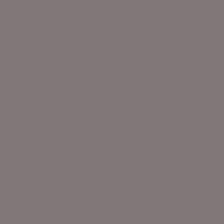

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 2, Minibatch/Iteration# : 9] Total Loss: 51.159
L1 Texture Loss is 51.15907499525282
Total Loss:  51.15907499525282
Epoch took 0.057620938618977866 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 3, Minibatch/Iteration# : 9] Total Loss: 49.488
L1 Texture Loss is 49.4883058336046
Total Loss:  49.4883058336046
Epoch took 0.05632693370183309 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 4, Minibatch/Iteration# : 9] Total Loss: 48.611
L1 Texture Loss is 48.6108029683431

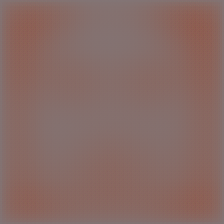

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 6, Minibatch/Iteration# : 9] Total Loss: 48.645
L1 Texture Loss is 48.64546330769857
Total Loss:  48.64546330769857
Epoch took 0.05563656489054362 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 7, Minibatch/Iteration# : 9] Total Loss: 46.666
L1 Texture Loss is 46.665854136149086
Total Loss:  46.665854136149086
Epoch took 0.05627227226893107 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 8, Minibatch/Iteration# : 9] Total Loss: 46.040
L1 Texture Loss is 46.0398139953

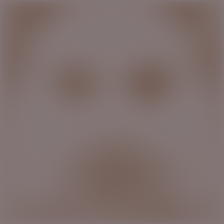

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 11, Minibatch/Iteration# : 9] Total Loss: 42.191
L1 Texture Loss is 42.19089126586914
Total Loss:  42.19089126586914
Epoch took 0.05632716417312622 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 12, Minibatch/Iteration# : 9] Total Loss: 42.215
L1 Texture Loss is 42.21539645724826
Total Loss:  42.21539645724826
Epoch took 0.05636293490727742 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 13, Minibatch/Iteration# : 9] Total Loss: 40.420
L1 Texture Loss is 40.419765472

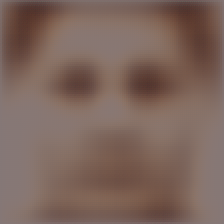

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 16, Minibatch/Iteration# : 9] Total Loss: 38.303
L1 Texture Loss is 38.3033447265625
Total Loss:  38.3033447265625
Epoch took 0.05627166827519735 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 17, Minibatch/Iteration# : 9] Total Loss: 38.377
L1 Texture Loss is 38.37718031141493
Total Loss:  38.37718031141493
Epoch took 0.05610768397649129 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 18, Minibatch/Iteration# : 9] Total Loss: 36.702
L1 Texture Loss is 36.70156224568

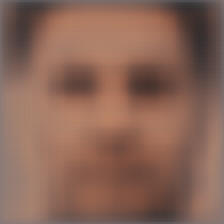

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 21, Minibatch/Iteration# : 9] Total Loss: 33.999
L1 Texture Loss is 33.998734368218315
Total Loss:  33.998734368218315
Epoch took 0.056974148750305174 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 22, Minibatch/Iteration# : 9] Total Loss: 31.663
L1 Texture Loss is 31.662968741522896
Total Loss:  31.662968741522896
Epoch took 0.05701302687327067 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 23, Minibatch/Iteration# : 9] Total Loss: 31.046
L1 Texture Loss is 31.0458

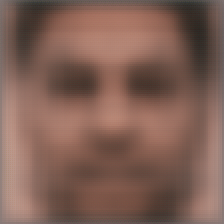

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 26, Minibatch/Iteration# : 9] Total Loss: 28.503
L1 Texture Loss is 28.503130806816948
Total Loss:  28.503130806816948
Epoch took 0.05648121436436971 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 27, Minibatch/Iteration# : 9] Total Loss: 28.365
L1 Texture Loss is 28.364741855197483
Total Loss:  28.364741855197483
Epoch took 0.05660753647486369 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 28, Minibatch/Iteration# : 9] Total Loss: 27.869
L1 Texture Loss is 27.86907

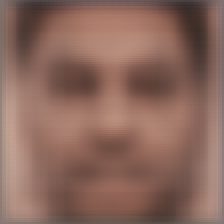

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 31, Minibatch/Iteration# : 9] Total Loss: 26.420
L1 Texture Loss is 26.42030864291721
Total Loss:  26.42030864291721
Epoch took 0.056784307956695555 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 32, Minibatch/Iteration# : 9] Total Loss: 25.818
L1 Texture Loss is 25.818058013916016
Total Loss:  25.818058013916016
Epoch took 0.05698062181472778 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 33, Minibatch/Iteration# : 9] Total Loss: 25.719
L1 Texture Loss is 25.718542

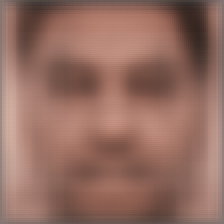

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 36, Minibatch/Iteration# : 9] Total Loss: 24.911
L1 Texture Loss is 24.910522249009873
Total Loss:  24.910522249009873
Epoch took 0.05679402748743693 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 37, Minibatch/Iteration# : 9] Total Loss: 24.597
L1 Texture Loss is 24.596946292453342
Total Loss:  24.596946292453342
Epoch took 0.05680290857950846 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 38, Minibatch/Iteration# : 9] Total Loss: 24.812
L1 Texture Loss is 24.81239

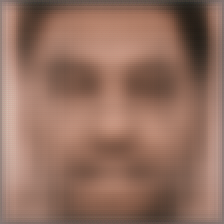

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 41, Minibatch/Iteration# : 9] Total Loss: 23.756
L1 Texture Loss is 23.756462309095596
Total Loss:  23.756462309095596
Epoch took 0.0567744255065918 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 42, Minibatch/Iteration# : 9] Total Loss: 23.621
L1 Texture Loss is 23.62120310465495
Total Loss:  23.62120310465495
Epoch took 0.056774246692657473 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 43, Minibatch/Iteration# : 9] Total Loss: 23.393
L1 Texture Loss is 23.3930229

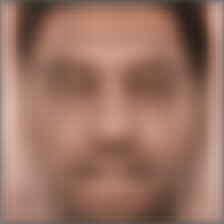

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 46, Minibatch/Iteration# : 9] Total Loss: 22.981
L1 Texture Loss is 22.981232113308376
Total Loss:  22.981232113308376
Epoch took 0.056758193174997966 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 47, Minibatch/Iteration# : 9] Total Loss: 23.398
L1 Texture Loss is 23.39820014105903
Total Loss:  23.39820014105903
Epoch took 0.05656768878300985 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 48, Minibatch/Iteration# : 9] Total Loss: 22.491
L1 Texture Loss is 22.490772

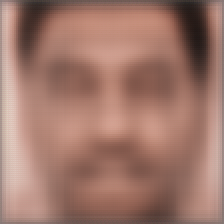

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 51, Minibatch/Iteration# : 9] Total Loss: 22.646
L1 Texture Loss is 22.64643669128418
Total Loss:  22.64643669128418
Epoch took 0.05707786480585734 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 52, Minibatch/Iteration# : 9] Total Loss: 22.289
L1 Texture Loss is 22.2892328898112
Total Loss:  22.2892328898112
Epoch took 0.05702155033747355 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 53, Minibatch/Iteration# : 9] Total Loss: 21.970
L1 Texture Loss is 21.97033182779

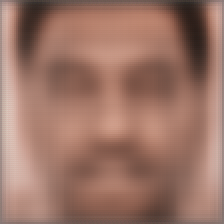

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 56, Minibatch/Iteration# : 9] Total Loss: 21.871
L1 Texture Loss is 21.871239344278973
Total Loss:  21.871239344278973
Epoch took 0.05645547310511271 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 57, Minibatch/Iteration# : 9] Total Loss: 21.938
L1 Texture Loss is 21.938344531589085
Total Loss:  21.938344531589085
Epoch took 0.05681725343068441 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 58, Minibatch/Iteration# : 9] Total Loss: 21.417
L1 Texture Loss is 21.41698

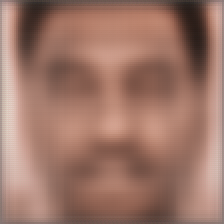

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 61, Minibatch/Iteration# : 9] Total Loss: 20.750
L1 Texture Loss is 20.750201331244575
Total Loss:  20.750201331244575
Epoch took 0.05677702824274699 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 62, Minibatch/Iteration# : 9] Total Loss: 20.906
L1 Texture Loss is 20.90647824605306
Total Loss:  20.90647824605306
Epoch took 0.05699934562047323 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 63, Minibatch/Iteration# : 9] Total Loss: 21.080
L1 Texture Loss is 21.0802684

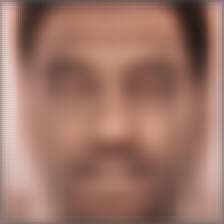

begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 66, Minibatch/Iteration# : 9] Total Loss: 20.886
L1 Texture Loss is 20.885718451605904
Total Loss:  20.885718451605904
Epoch took 0.05668025811513265 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 67, Minibatch/Iteration# : 9] Total Loss: 20.552
L1 Texture Loss is 20.55168914794922
Total Loss:  20.55168914794922
Epoch took 0.056365692615509035 minutes
---------------------------------------------------------------
begin loading samples to memory
finish loading samples to memory
990  samples loaded!
---------------------------------------------------------------
[Epoch# : 68, Minibatch/Iteration# : 9] Total Loss: 20.837
L1 Texture Loss is 20.837267

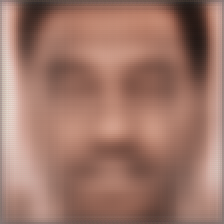

begin loading samples to memory
finish loading samples to memory
405  samples loaded!


RuntimeError: ignored

In [ ]:
from random import shuffle
%cd /content/face_morpher
import facemorpher
%cd /content

img_list=os.listdir(dataPath)
shuffle(img_list)
print("Total images in folder: ", len(img_list))

img_list=img_list[:150000]
img_list_size=len(img_list)

print("Total dataset size: ", img_list_size)

if curr_epoch != 1:
  curr_epoch +=1

counter = 0
while counter<50: # CHANGE THIS TO 3333 for nextt 
    i=0
    shuffle(img_list)
    while i < img_list_size:

        ender=0
        if i+1000 >= img_list_size:
          ender=img_list_size
        else:
          ender=i+1000



        trainSet = FrontFacingNeutralDataset(dataPath, img_list[i:ender])

        trainLoader = DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=workers)

        torch.cuda.empty_cache()
        import cv2
        train(curr_epoch)

        if(curr_epoch%10==0):
                  print("=> Saving model to Google Drive <=")
                  path = "/content/gdrive/MyDrive/sample/Pre-trained models/morpher_weights/"
                  path = path + str(curr_epoch) + ".pt"
                    
                  torch.save({
                                'curr_epoch': curr_epoch,
                                'net_state_dict': net.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                }, path)
                  testset_loss()
                  
                  
                  
        if(curr_epoch == 1 or curr_epoch%5==0):
                  #'We must make a test heree!!!'
                  net.eval()
                   
                  input = cv2.imread("ak.png")
                  src_points = facemorpher.locator.face_points(input)
                  output_img = facemorpher.averager(["ak.png"],width=224,height=224)
                  cv2.imwrite("result.png",input)
                  res = cv2.imread("result.png")
                  print(res.shape)
                  output = net.test(res,encoder) 
                  from google.colab.patches import cv2_imshow
                  cv2_imshow(output)
         

        curr_epoch+=1

        i+=1000

    counter+=1